### Import

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display
# import pymannkendall as mk

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
import nclcmaps as nclc

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                                      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

### AR Data

In [3]:
mode = 'max'

if mode == 'mean':
    df = pd.read_csv(path_to_out + 'DJFMAM_ivt_ar_types_ERA5_prec_mean.csv')
    ylim_max = 150
elif mode == 'max':
    df = pd.read_csv(path_to_out + 'DJFMAM_ivt_ar_types_ERA5_prec_max.csv')
    ylim_max = 305
elif mode == 'perc':
    df = pd.read_csv(path_to_out + 'DJFMAM_ivt_ar_types_ERA5_prec_perc.csv')
    ylim_max = 305

In [4]:
## add month and year columns
df = df.drop(columns=['Unnamed: 0'])
frame = pd.to_datetime(df.start_date.values)
frame = pd.DataFrame([frame]).transpose()
frame['date']= frame
df['month']= frame['date'].dt.month
df['year']= frame['date'].dt.year

## select only AR events that resulted in more than 0.1 mm of rainfall per event
idx = (df.northwestern > 0.1) | (df.western > 0.1) | (df.eastern > 0.1) | (df.zagros > 0.1)
df = df.loc[idx]
print(len(df))

df

1805


,trackID,ar_cat,start_date,end_date,duration,ivty,ivtx,ivt,hlat,hlon,...,lightning_northwestern,lightning_western,lightning_eastern,lightning_zagros,northwestern,western,eastern,zagros,month,year
0,2861.0,1,1979-12-02 00:00:00,1979-12-02 18:00:00,18.0,84.715817,156.934744,178.340359,54.000000,88.950000,...,0.0,0.0,0.0,0.0,33.108181,19.348969,98.042885,NaN,12,1979
2,2975.0,1,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0,123.568145,129.182257,178.765606,40.000000,64.000000,...,0.0,0.0,0.0,0.0,11.874307,6.085221,40.997482,NaN,12,1979
3,2988.0,1,1979-12-21 00:00:00,1979-12-22 12:00:00,36.0,118.158087,138.478370,182.037338,33.600000,56.800000,...,0.0,0.0,0.0,0.0,24.330225,30.647057,36.209976,13.484436,12,1979
5,3033.0,1,1979-12-24 18:00:00,1979-12-25 00:00:00,6.0,93.446963,108.000093,142.815808,25.500000,83.500000,...,0.0,0.0,0.0,0.0,1.550887,18.826612,1.416227,8.670099,12,1979
6,3038.0,1,1979-12-28 00:00:00,1979-12-28 18:00:00,18.0,86.515695,157.560104,179.750248,30.923077,60.807692,...,0.0,0.0,0.0,0.0,6.596806,7.065341,26.775162,2.407128,12,1979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,128445.0,3,2019-04-17 12:00:00,2019-04-18 00:00:00,12.0,80.578265,261.007236,273.162285,24.750000,102.000000,...,0.0,0.0,0.0,0.0,5.458248,20.746841,62.335579,43.005138,4,2019
2680,128539.0,3,2019-04-30 18:00:00,2019-05-01 00:00:00,6.0,72.876333,220.196722,231.943003,56.125000,108.375000,...,0.0,0.0,0.0,0.0,9.942412,31.153824,88.585373,1.186878,4,2019
2683,128602.0,3,2019-05-05 06:00:00,2019-05-06 00:00:00,18.0,109.959835,211.849620,238.686880,29.000000,103.000000,...,0.0,0.0,0.0,0.0,1.998601,1.903410,103.896339,3.885193,5,2019
2686,128755.0,3,2019-05-24 00:00:00,2019-05-24 06:00:00,6.0,59.469964,404.299149,408.649579,24.000000,100.500000,...,0.0,0.0,0.0,0.0,18.653128,43.061131,120.298950,6.096446,5,2019


In [5]:
## Show trends of mean IVT for each type of AR


267


/tmp/ipykernel_244779/4197903996.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array(([239/256, 86/256, 69/256, 1], # UCSB coral


270
300
267
270
300
267
270
300
267
270
300
../figs/ivt_precip_scatter_era5_max.png


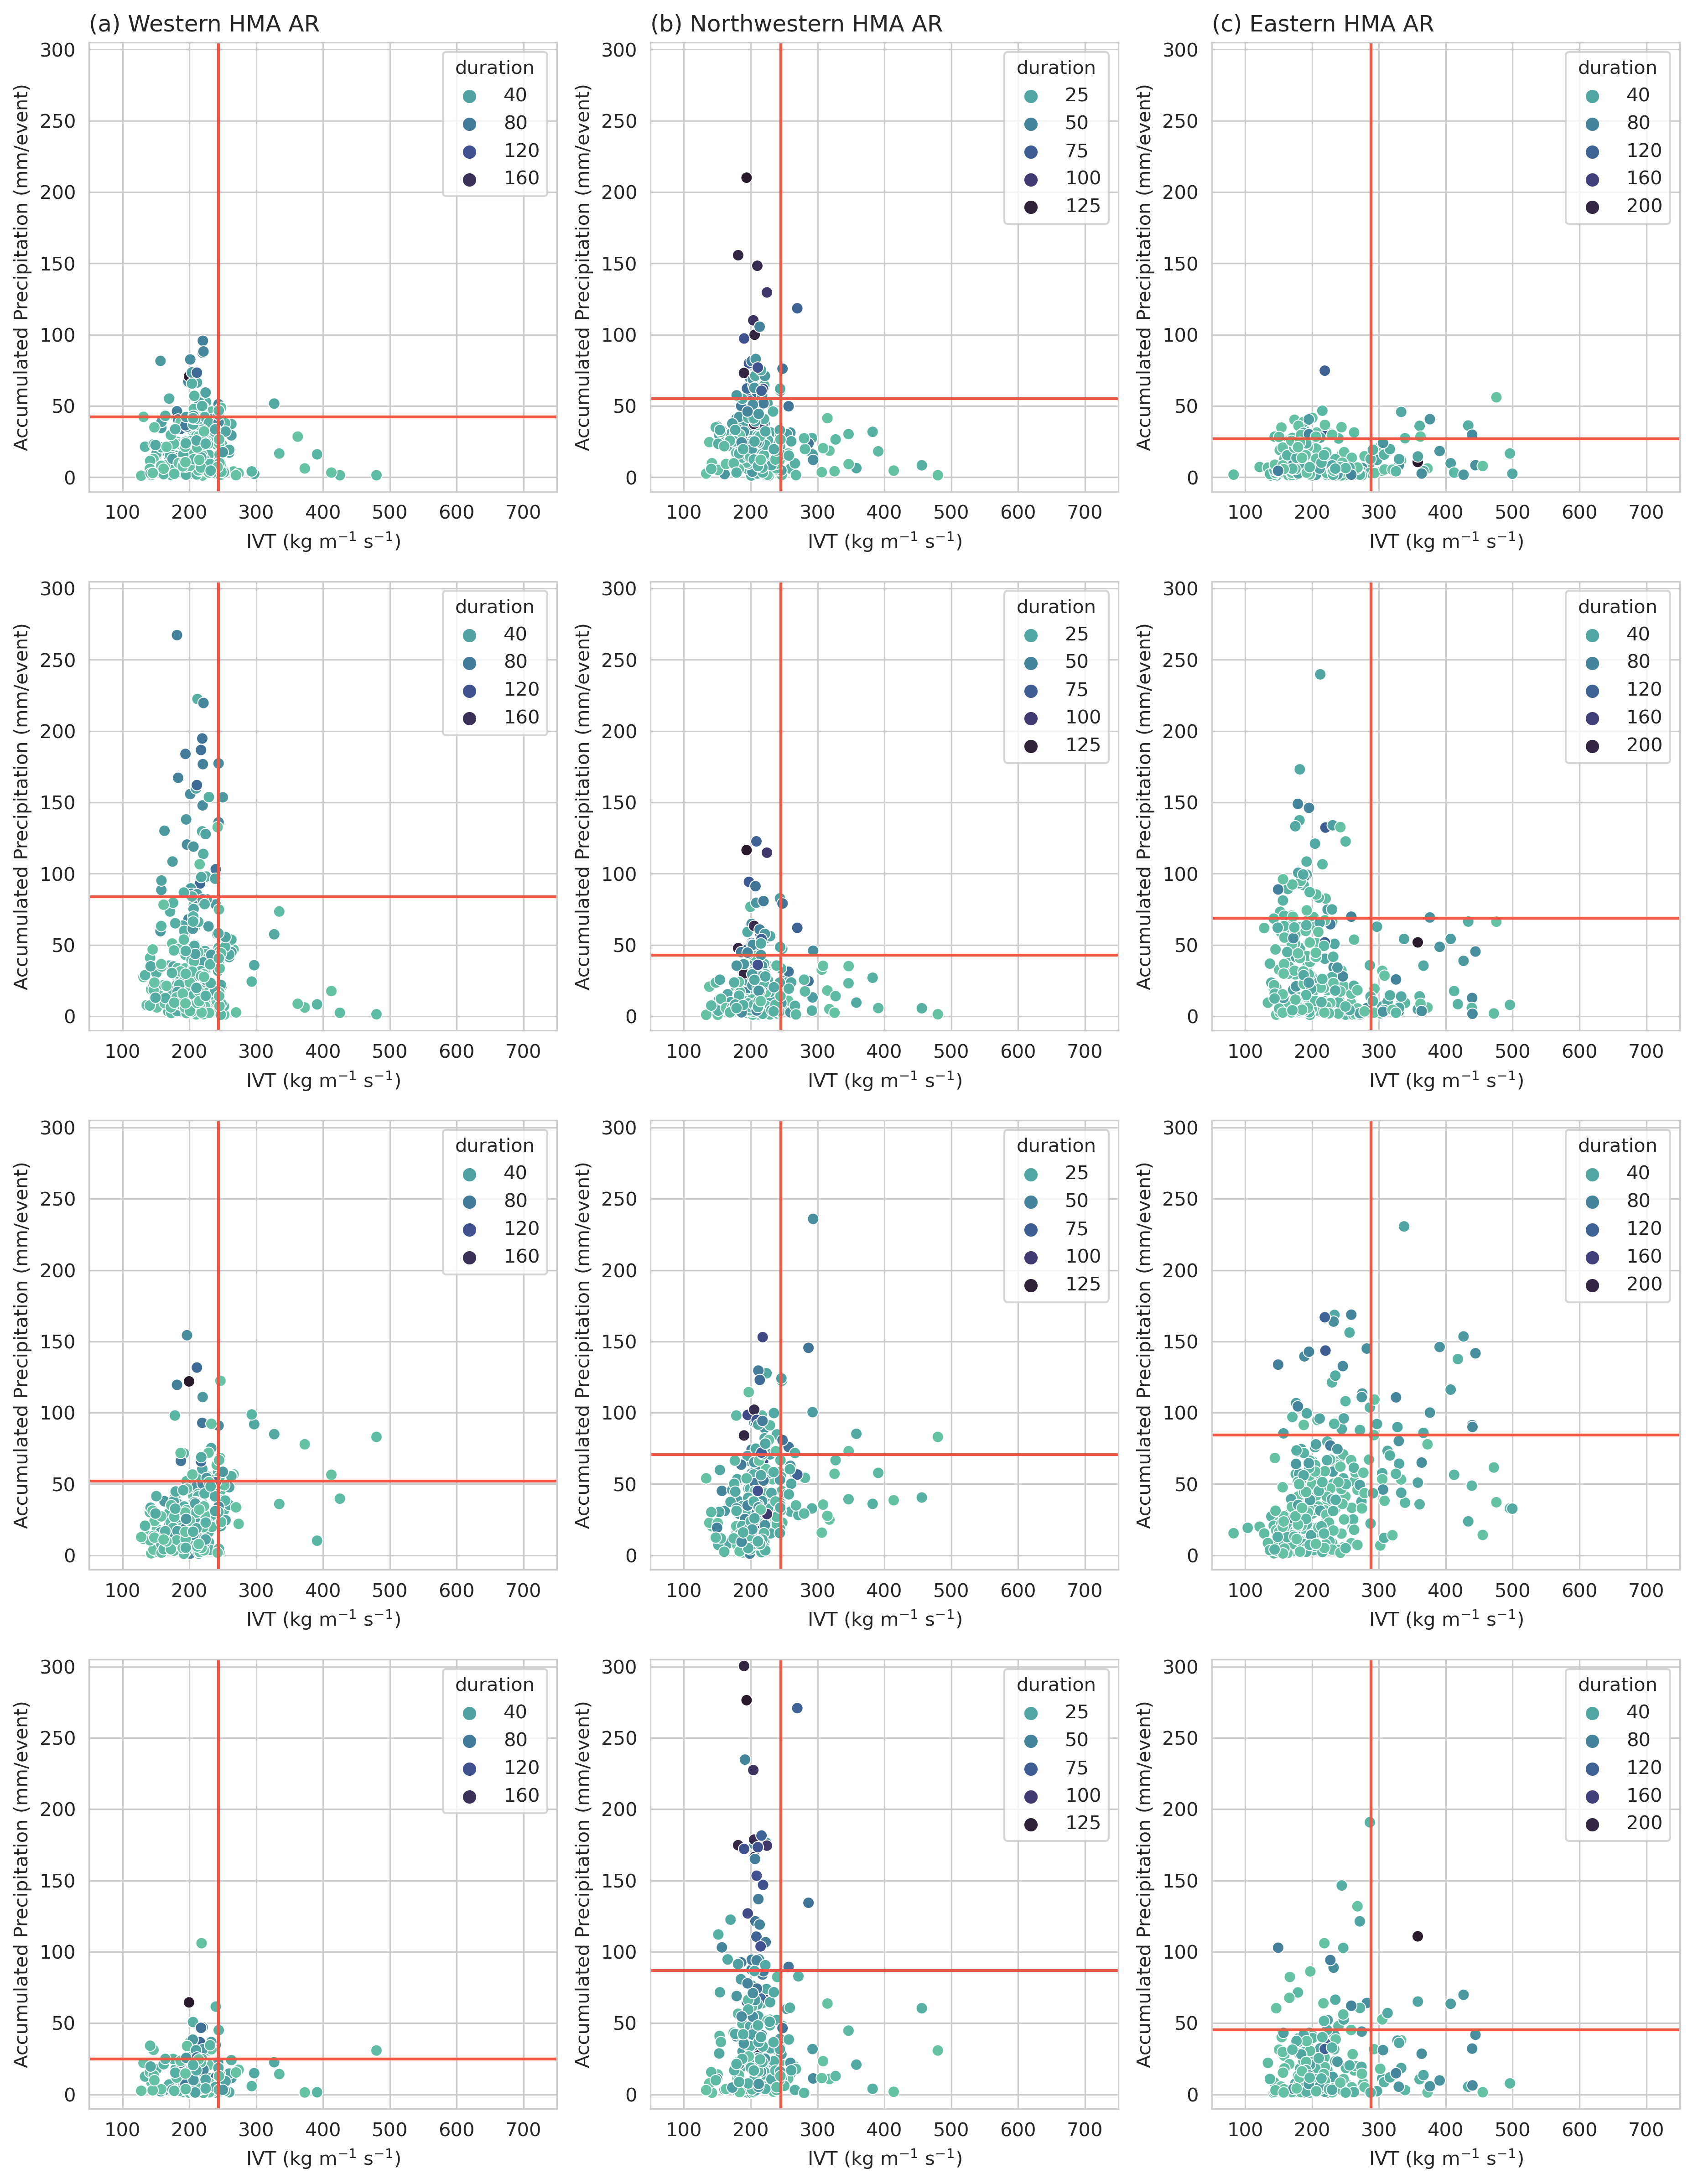

<Figure size 1080x1440 with 0 Axes>

In [6]:
## update plot so that it is 3 columns (ar type) by 4 rows (location of precip)
fname = path_to_figs + 'ivt_precip_scatter_era5_' + mode
fmt = 'png'
nrows = 4
ncols = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(15,20))

region_lst = ['northwestern']*3 + ['western']*3 + ['eastern']*3 + ['zagros']*3
artype_lst = [1, 2, 3]*4
plt_lbl = ['(a) Western HMA AR', '(b) Northwestern HMA AR', '(c) Eastern HMA AR'] + ['']*9

colors = np.array(([239/256, 86/256, 69/256, 1], # UCSB coral
                   [254/256, 188/256, 17/256, 1], # UCSB gold
                   [4/256, 124/256, 145/256], # UCSB aqua
                   [156/256, 190/256, 190/256], # UCSB mist
                  ))

case_study = [(97756, 88295), (81714, 97756), (98243, 28941)]

sns.set_style("whitegrid")

for i, (region, ar_type) in enumerate(zip(region_lst, artype_lst)):
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    # plot DJF cases
    idx = ((df.month >= 12) | (df.month <= 2))
    data1 = df.loc[idx]
    idx = (data1.ar_cat == ar_type) 
    data1 = data1.loc[idx]
    print(len(data1))
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 30, which='min', N=None)
    g = sns.scatterplot(data=data1, x="ivt", y=region, hue='duration', ax=ax, palette=clipcmap)
    
    ## get 85th percentile of ivt and precip
    ivt_thres = data1['ivt'].describe(percentiles=[.85]).loc['85%']
    prec_thres = data1[region].describe(percentiles=[.85]).loc['85%']
    
    plt.axhline(y=prec_thres, color=colors[0], linestyle='-')
    plt.axvline(x=ivt_thres, color=colors[0], linestyle='-')
    
    # # plot case study points
    # idx = (data1.trackID == case_study[i][0]) | (data1.trackID == case_study[i][1])
    # idx = (data1.trackID == 97756)
    # data3 = data1.loc[idx]
    # gb = sns.scatterplot(data=data3, x="ivt", y="prec", ax=ax, marker='o', color=colors[1], s=100)
    
#     # plot landslide cases
#     idx = (data1.landslide == 1) & (np.abs(data1.landslide_lat - data1.hlat) < 10) & (np.abs(data1.landslide_lon - data1.hlon) < 10)
#     data2 = data1.loc[idx]
#     print(len(data2))
#     ga = sns.scatterplot(data=data2, x="ivt", y="prec", ax=ax, marker='X', color=colors[0])
    
    
    ax.set_ylabel('Accumulated Precipitation (mm/event)')
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    ax.set_ylim(-10, ylim_max)
    ax.set_xlim(50, 750)
    ax.set_title(plt_lbl[i], loc='left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [7]:
## select NW AR type
idx = (df.ar_cat == 2)
data1 = df.loc[idx]

## select events above 95th percentile of Zagros area precip
prec_thres_zag = data1['zagros'].describe(percentiles=[.85]).loc['85%']
idx = (df.zagros >= prec_thres_zag)
data2 = df.loc[idx]
# data2

## select events above 95th percentile of Northwestern area precip
prec_thres_nw = data1['northwestern'].describe(percentiles=[.85]).loc['85%']
idx = (df.northwestern >= prec_thres_nw)
data3 = df.loc[idx]

../figs/ivt_precip_scatter_zagros_85th_max.png


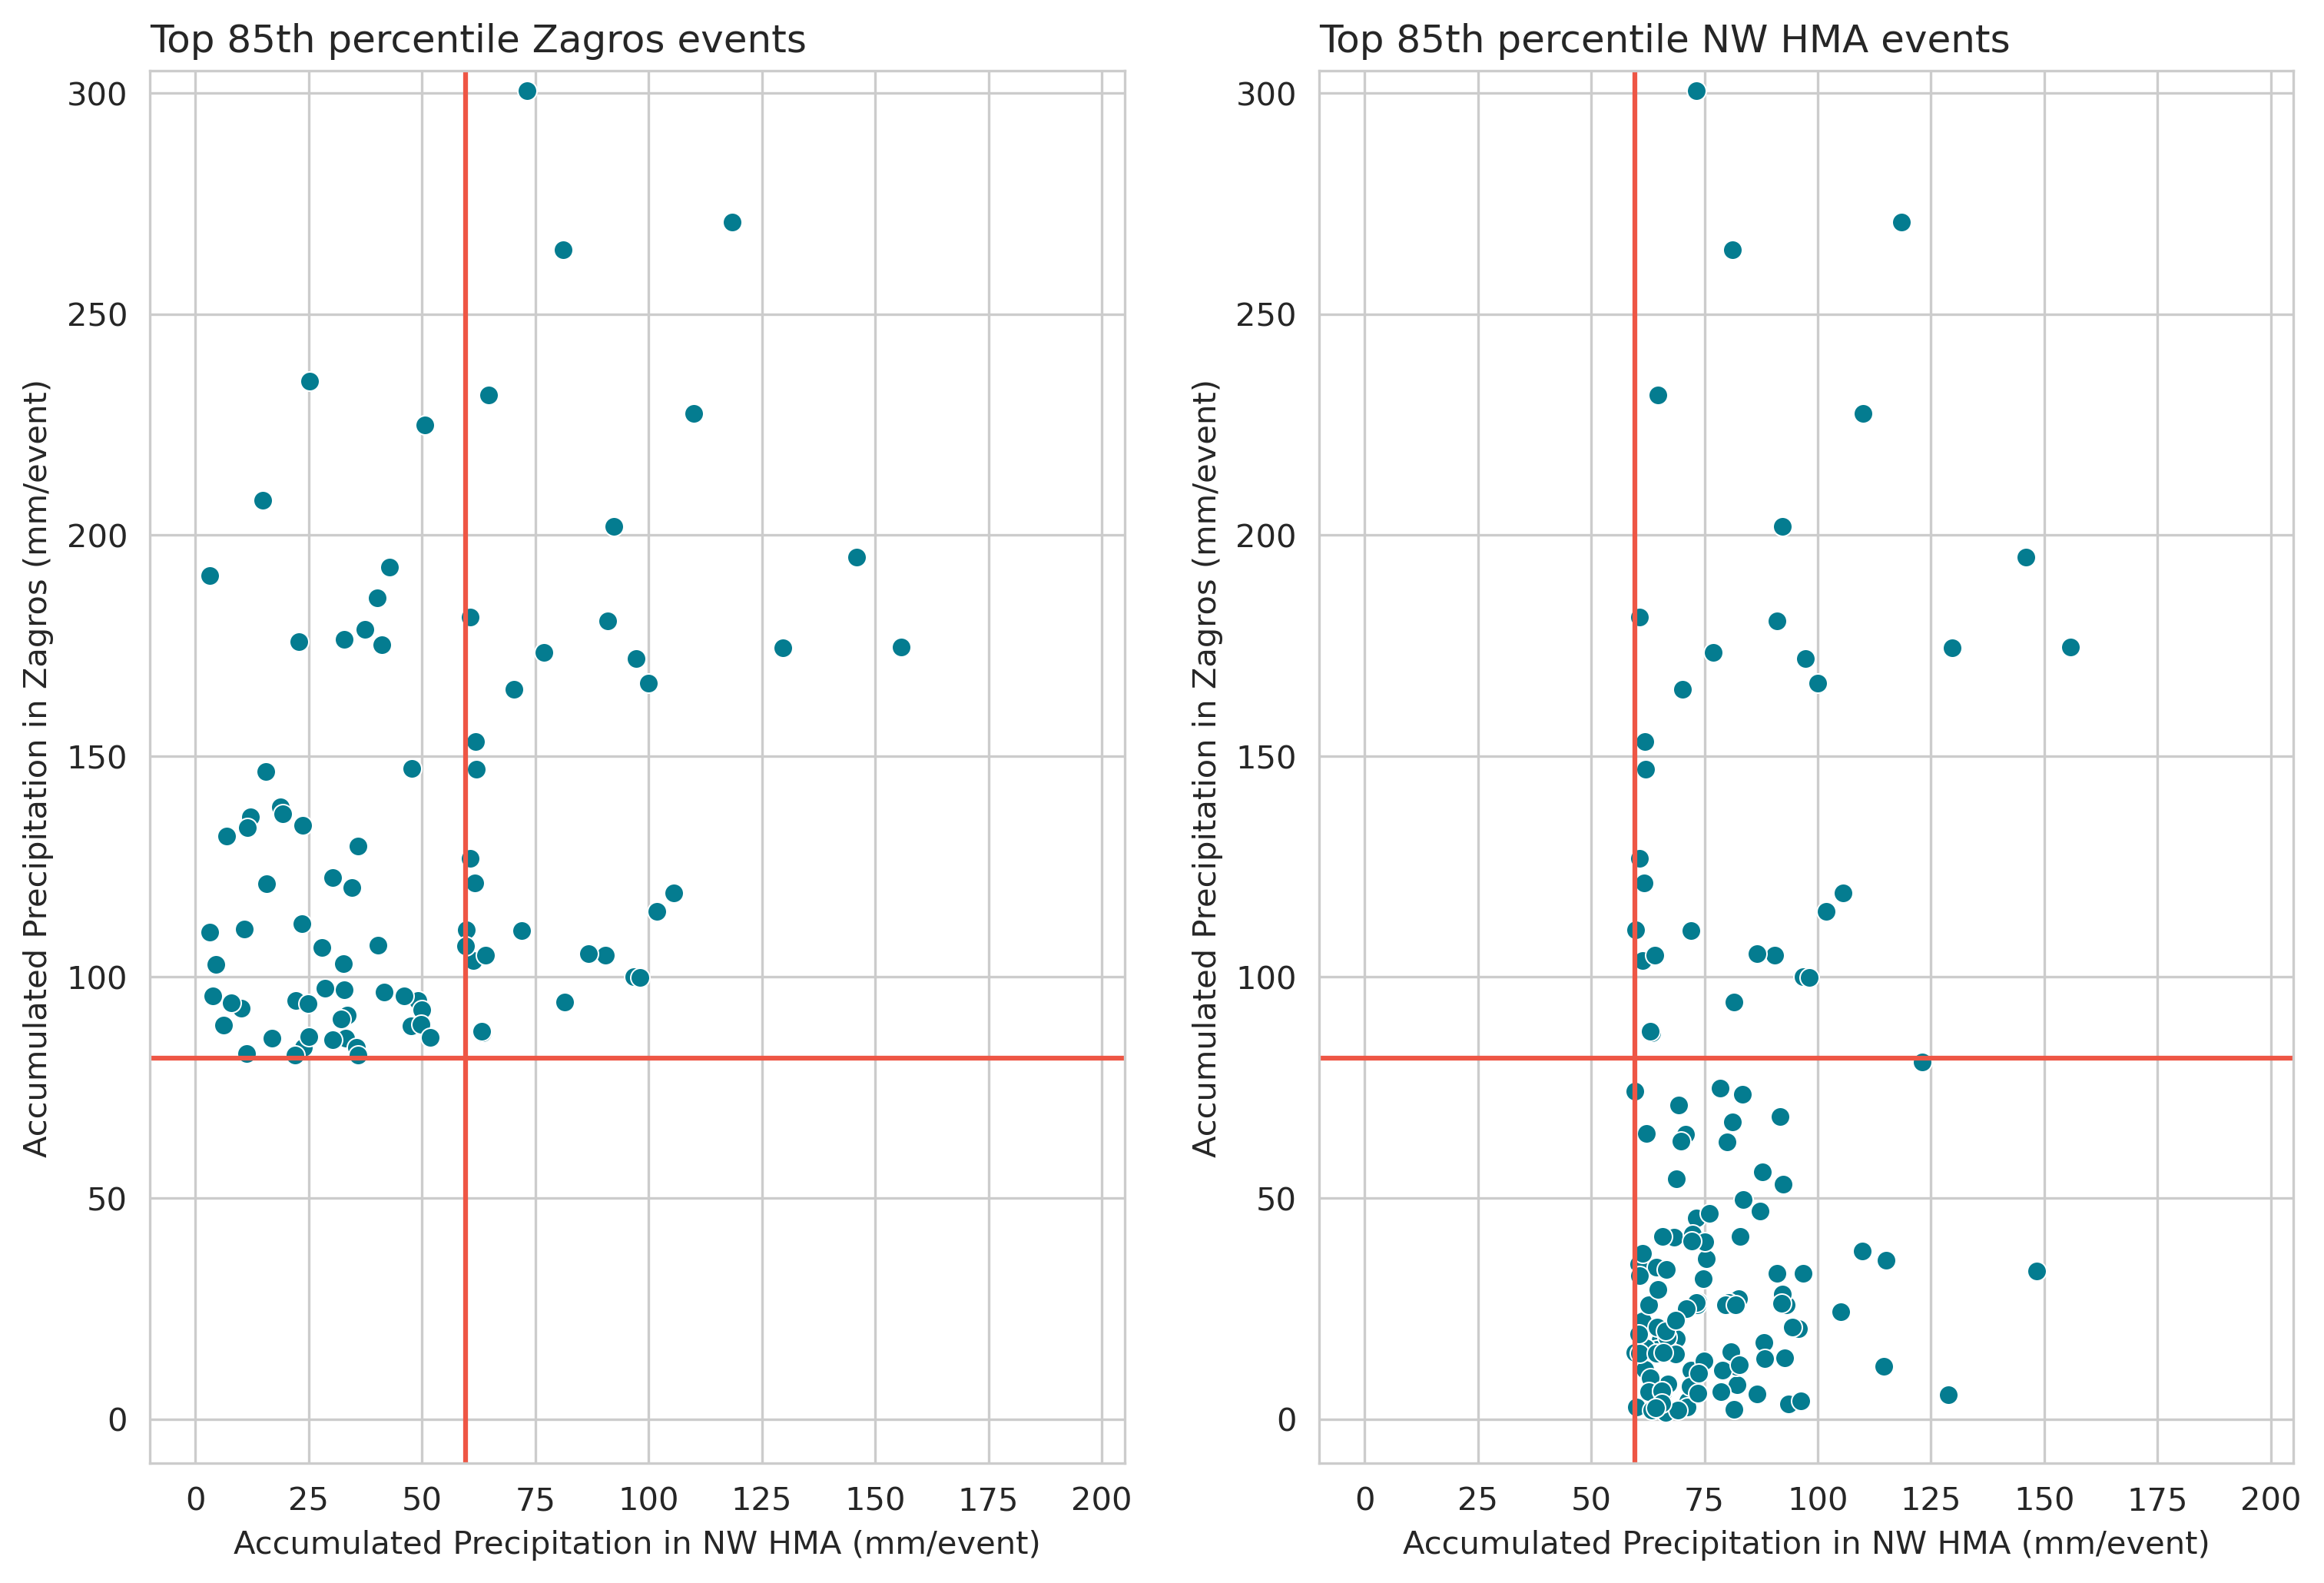

<Figure size 864x576 with 0 Axes>

In [8]:
## plot single scatter plot
# zagros precip 1 color, NW precip another color

## update plot so that it is 3 columns (ar type) by 4 rows (location of precip)
fname = path_to_figs + 'ivt_precip_scatter_zagros_85th_' + mode
fmt = 'png'
nrows = 1
ncols = 2
nplots=1

fig = plt.figure(figsize=(12,8))


sns.set_style("whitegrid")

# plot zagros precip vs. Northwestern precip for extreme Zagros events
ax = fig.add_subplot(nrows, ncols, 1)
g = sns.scatterplot(data=data2, x="northwestern", y="zagros", ax=ax, color=colors[2])

plt.axhline(y=prec_thres_zag, color=colors[0], linestyle='-')
plt.axvline(x=prec_thres_nw, color=colors[0], linestyle='-')

ax.set_ylabel('Accumulated Precipitation in Zagros (mm/event)')
ax.set_xlabel('Accumulated Precipitation in NW HMA (mm/event)')
ax.set_ylim(-10, ylim_max)
ax.set_xlim(-10, 205)
ax.set_title('Top 85th percentile Zagros events', loc='left')

# plot zagros precip vs. Northwestern precip for extreme NW HMA events
ax = fig.add_subplot(nrows, ncols, 2)
g = sns.scatterplot(data=data3, x="northwestern", y="zagros", ax=ax, color=colors[2])

plt.axhline(y=prec_thres_zag, color=colors[0], linestyle='-')
plt.axvline(x=prec_thres_nw, color=colors[0], linestyle='-')

ax.set_ylabel('Accumulated Precipitation in Zagros (mm/event)')
ax.set_xlabel('Accumulated Precipitation in NW HMA (mm/event)')
ax.set_ylim(-10, ylim_max)
ax.set_xlim(-10, 205)
ax.set_title('Top 85th percentile NW HMA events', loc='left')

    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

267
270
300
../figs/ivt_precip_scatter_era5_max_3col.png


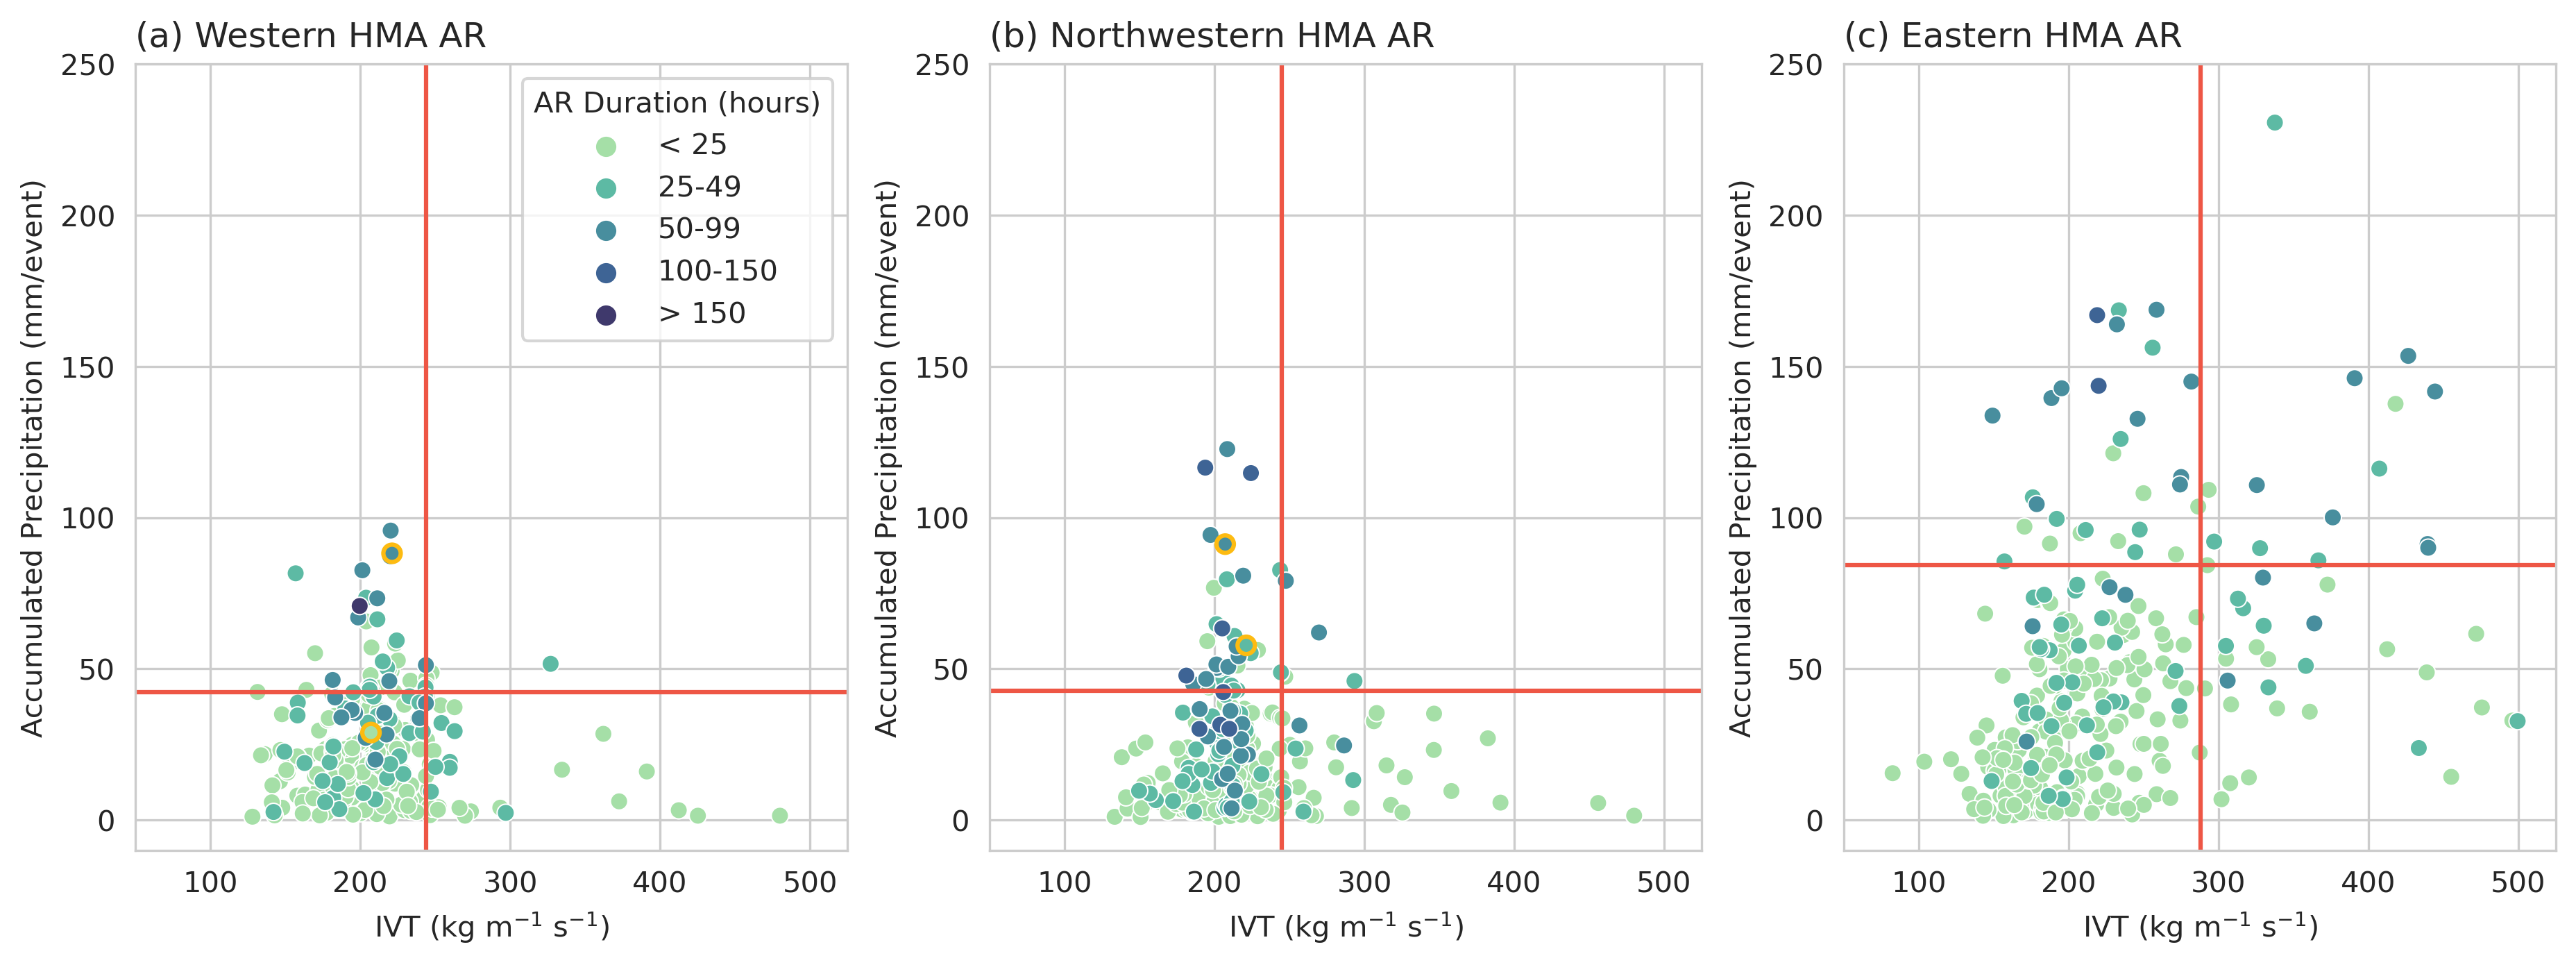

<Figure size 1080x360 with 0 Axes>

In [24]:
## update plot so that it is 3 columns (ar type) by 1 rows (location of precip)
fname = path_to_figs + 'ivt_precip_scatter_era5_' + mode + '_3col'
fmt = 'png'
nrows = 1
ncols = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(15,5))

region_lst = ['northwestern'] + ['western'] + ['eastern']
artype_lst = [1, 2, 3]
plt_lbl = ['(a) Western HMA AR', '(b) Northwestern HMA AR', '(c) Eastern HMA AR']

colors = np.array(([239/256, 86/256, 69/256, 1], # UCSB coral
                   [254/256, 188/256, 17/256, 1], # UCSB gold
                   [4/256, 124/256, 145/256], # UCSB aqua
                   [156/256, 190/256, 190/256], # UCSB mist
                  ), dtype='object')

case_study = [(71513, 97756), (71513, 97756), (71513, 97756)]

sns.set_style("whitegrid")
legend_lst = [True, False, False]

for i, (region, ar_type) in enumerate(zip(region_lst, artype_lst)):
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    # plot ALL cases
    idx = ((df.month >= 12) | (df.month <= 2))
    data1 = df.loc[idx]
    idx = (data1.ar_cat == ar_type) 
    data1 = data1.loc[idx]
    print(len(data1))
    # sort data
    test=data1.sort_values('duration')
    test['AR Duration (hours)'] = pd.cut(test["duration"], [0, 25, 50, 100, 150, 300], labels=["< 25", "25-49", "50-99", "100-150", "> 150"])
    cpal = sns.color_palette("cmo.deep", n_colors=5)
    g = sns.scatterplot(data=test, x="ivt", y=region, ax=ax, hue='AR Duration (hours)',  palette=cpal, legend=legend_lst[i])
    
    ## get 85th percentile of ivt and precip
    ivt_thres = data1['ivt'].describe(percentiles=[.85]).loc['85%']
    prec_thres = data1[region].describe(percentiles=[.85]).loc['85%']
    
    plt.axhline(y=prec_thres, color=colors[0], linestyle='-')
    plt.axvline(x=ivt_thres, color=colors[0], linestyle='-')
    
    # # plot case study points
    idx = (test.trackID == case_study[i][0]) | (test.trackID == case_study[i][1])
    # idx = (data1.trackID == 97756)
    data3 = test.loc[idx]
    kwargs = {'edgecolor': colors[1], 'linewidth': 1.5}
    gb = sns.scatterplot(data=data3, x="ivt", y=region, ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    # gb = sns.scatterplot(data=data3, x="ivt", y="prec", ax=ax, marker='o', color=colors[1], s=100, ms=100, mec=colors[1], mfc="None")
    
#     # plot landslide cases
#     idx = (data1.landslide == 1) & (np.abs(data1.landslide_lat - data1.hlat) < 10) & (np.abs(data1.landslide_lon - data1.hlon) < 10)
#     data2 = data1.loc[idx]
#     print(len(data2))
#     ga = sns.scatterplot(data=data2, x="ivt", y="prec", ax=ax, marker='X', color=colors[0])
    
    
    ax.set_ylabel('Accumulated Precipitation (mm event$^{-1}$)')
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    ax.set_ylim(-10, 250)
    ax.set_xlim(50, 525)
    ax.set_title(plt_lbl[i], loc='left')
    
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title="Duration of AR", frameon=False) ## only works with seaborn version 0.11.2

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))